In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters ###################################################################

max_firing_rate = 5         # (per second)
mean_firing_threshold = 0.5 # [Theta] (mV), half of the maximum response of the pop

# Sigmoid slopes (mV^-1) 
r_0 = 0.56
r_1 = 0.56
r_2 = 0.56

# Inverse time constants (s^-1)
# Smaller value, slower effect.. 
a = 100 # excitatory 
ad = 50 # long-range excitatory
b = 50  # inhibitory

# Maximum amplitudes of post-synaptic potential (PSPs) (mV)
A = 3.25 # excitatory
B = 22.0 # inhibitory

# Connectivity constants
C = 135         # Global synaptic connectivity
C1 = C          # Connectivity between Pyramidal and Excitatory
C2 = 0.8 * C    # Connectivity between Excitatory and Pyramidal
C3 = 0.25 * C   # Connectivity between Pyramidal and Inhibitory
C4 = 0.25 * C   # Connectivity between Inhibitory and Pyramidal

# Modified Jansen & Rit Parameters 
# Cholinergic modulation of inhibitory circuits and the segregation/integration balance

# Both as multiples of C
alpha = 0 # excitatory gain, connectivity between long-range pyramidal 
beta = 0  # inhibitory gain, connectibity between inhibitory and excitatory interneuron (short range)

# Structural Connectivity Matrix
num_nodes = 100
SC = np.genfromtxt('SC_in_Schaefer-100.csv', delimiter=',')

max_firing_rate = 5
mean_firing_threshold = 6

Hyperparameters

A, B, a, b, ad 

But IPSPs (inhibitory post synaptic potential) A, a have longer amplitude and latency than ESPSs (excitatory post synaptic
potential), B, b based on their biological structure.

C

max_firing_rate, mean_firing_threshold

r_0, r_1, r_2

In [93]:
# Sigmoid Function - transforms the postynaptic potential (PSP) into an average pulse density 
# v is the average psp, r is the slope of the sigmoid function
# def sigmoid(v, r):
#     return max_firing_rate / (1 + np.exp(r * (mean_firing_threshold - v))) # output is num_nodes x 1 

def sigmoid(v,r):
    return max_firing_rate  / (1 + np.exp(r * (mean_firing_threshold - v)))

# PSPs ###################################################################
# t is average pulse density/spike rate 

# Excitatory PSP
def epsp(t):
    if t < 0:
        return 0
    else:
        return A * a * t * np.exp(-a * t)
    
# Inhibitory PSP
def ipsp(t):
    if t < 0:
        return 0
    else:
        return B * b * t * np.exp(-b * t)

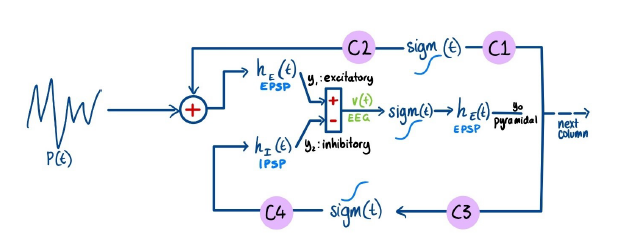

In [94]:
# x3 is a vector of size num_nodes by 1
def calculate_zi(x3):
    return np.dot(SC, x3) # output num_nodes x 1

# System of Equations ########################################################  

norm = np.sqrt(np.sum(SC, axis = 1) * np.sum(SC, axis = 0))
# Expanded Jansen & Rit Model 
def system_of_equations(x):
    x0, y0, x1, y1, x2, y2, x3, y3 = x

    # Noise  - uncorrelated Gaussian-distributed noise with mean 2 and standard deviation 2
    noise = np.random.normal(2,2,num_nodes) # produces a num_nodes x 1 vector 

    dx0dt = y0
    dy0dt = A * a * (sigmoid(C2 * x1 - C4 * x2 + C * alpha * calculate_zi(x3), r_0)) - 2 * a * y0 - a**2 * x0
    dx1dt = y1
    dy1dt = A * a * (noise + sigmoid(C1 * x0 - C * beta * x2, r_1)) - 2 * a * y1 - a**2 * x1
    dx2dt = y2
    dy2dt = B * b * sigmoid(C3 * x0, r_2) - 2 * b * y2 - b**2 * x2
    dx3dt = y3
    dy3dt = A * ad * (sigmoid(C2 * x1 - C4 * x2 + C * alpha * calculate_zi(x3), r_0)) - 2 * ad * y3 - ad**2 * x3
    return [dx0dt, dy0dt, dx1dt, dy1dt, dx2dt, dy2dt, dx3dt, dy3dt] # num_nodes x 8 matrix output 


TR - repetition time.  
Sampling frequency = 1 / TR. 

Functional MRI data were collected using a T2*-weighted echoplanar imaging (EPI) sequence with the following parameters: slice thickness=4 mm, 34 slices, TR=2 s, TE=30 ms, flip angle=90°, matrix 64×64, FOV=192 mm, oblique slice orientation.

So, bold sampling frequency = 1/2 = 0.5 Hz. (i.e. one data point acquired every 2 seconds)

Fix downsampling so sampling freq matches empirical EEG (1000 Hz) or BOLD (0.5 Hz) 

Sampling freq = 1 / dt = 1000 Hz

Downsampling to use = current sampling freq / intended sampling freq


In [95]:
eeg_freq = 1000
bold_freq = 0.5

# Simulation parameters
dt = 0.001 # Step size
transient = 60  # Simulation duration for stabilizing (with Euler method)
sim_length = 600 # Simulation time points (to plot)

downsample_eeg = (1 / dt) / eeg_freq
downsample_bold = (1 / dt) / bold_freq

# Initial conditions
initial_conditions = np.ones((8, num_nodes)) * 0.5

total_sims = int((transient + sim_length/ dt) - 1)
total_downsampled_sims = int(total_sims / downsample_eeg)

# Array to store results
sol = np.zeros((total_downsampled_sims, 8, num_nodes))
sol[0,:,:] = np.copy(initial_conditions) #First set of initial conditions
y_temp = np.copy(initial_conditions)

# Run simulation using Euler method
for i in range(1, total_sims - 1):
    y_temp += dt * np.array(system_of_equations(y_temp))
    if i % downsample_eeg == 0:
        sol[int(i/downsample_eeg) - 1] = np.copy(y_temp)

In [96]:
from sklearn import datasets

# Store results ##########################################################

x1 = sol[:, 2]
x2= sol[:, 4]
x3 = np.apply_along_axis(calculate_zi, axis=1, arr=sol[:, 6])

%store x1
%store x2
%store x3

Stored 'x1' (ndarray)
Stored 'x2' (ndarray)
Stored 'x3' (ndarray)


Stored 'V_T_sim' (ndarray)


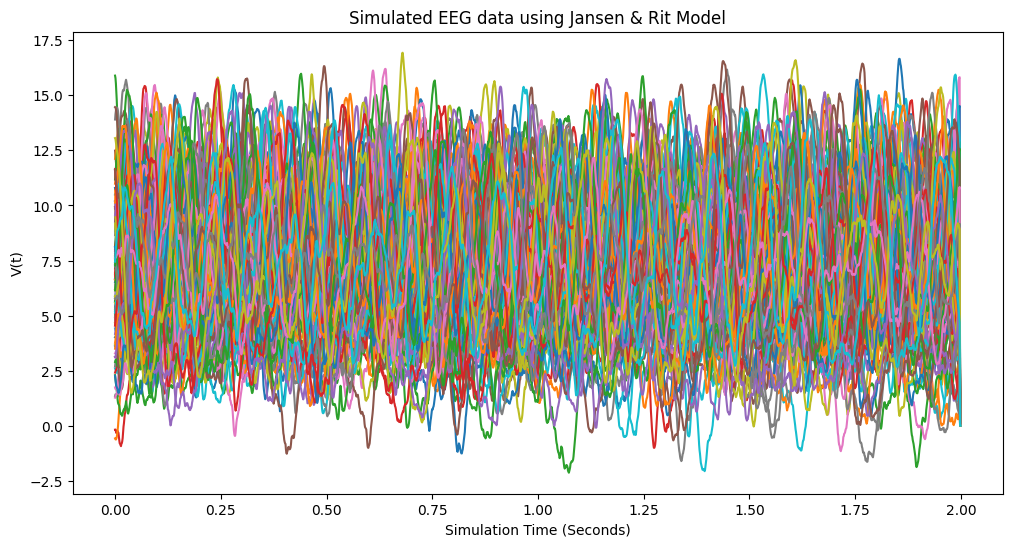

In [103]:
# Plot EEG Results #################################################################
# Normalise each channel for standard deviation ?

# eeg_freq is 1000Hz, i.e. 1000 points per second. So 2000 points in 2 seconds. 
time_points_in_2_secs = int(2 * eeg_freq)

# With vectorised operations, calculate for each simulation point
V_T = C2 * x1 - C4 * x2 + C * alpha * x3

# Take final sim_length as simulation results
V_T_sim = V_T[-time_points_in_2_secs:]

%store V_T_sim

plt.figure(figsize=(12, 6)) 

V_T_plot = V_T[-time_points_in_2_secs:]

time_seconds = np.arange(V_T_plot.shape[0]) / eeg_freq

# Plot V_T for each node
for node in range(num_nodes):
    plt.plot(time_seconds, V_T_plot[:, node], label=f'Node {node+1}')

plt.xlabel('Simulation Time (Seconds)')
plt.ylabel('V(t)')
plt.title('Simulated EEG data using Jansen & Rit Model')

# Add legend to the right of the plot
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

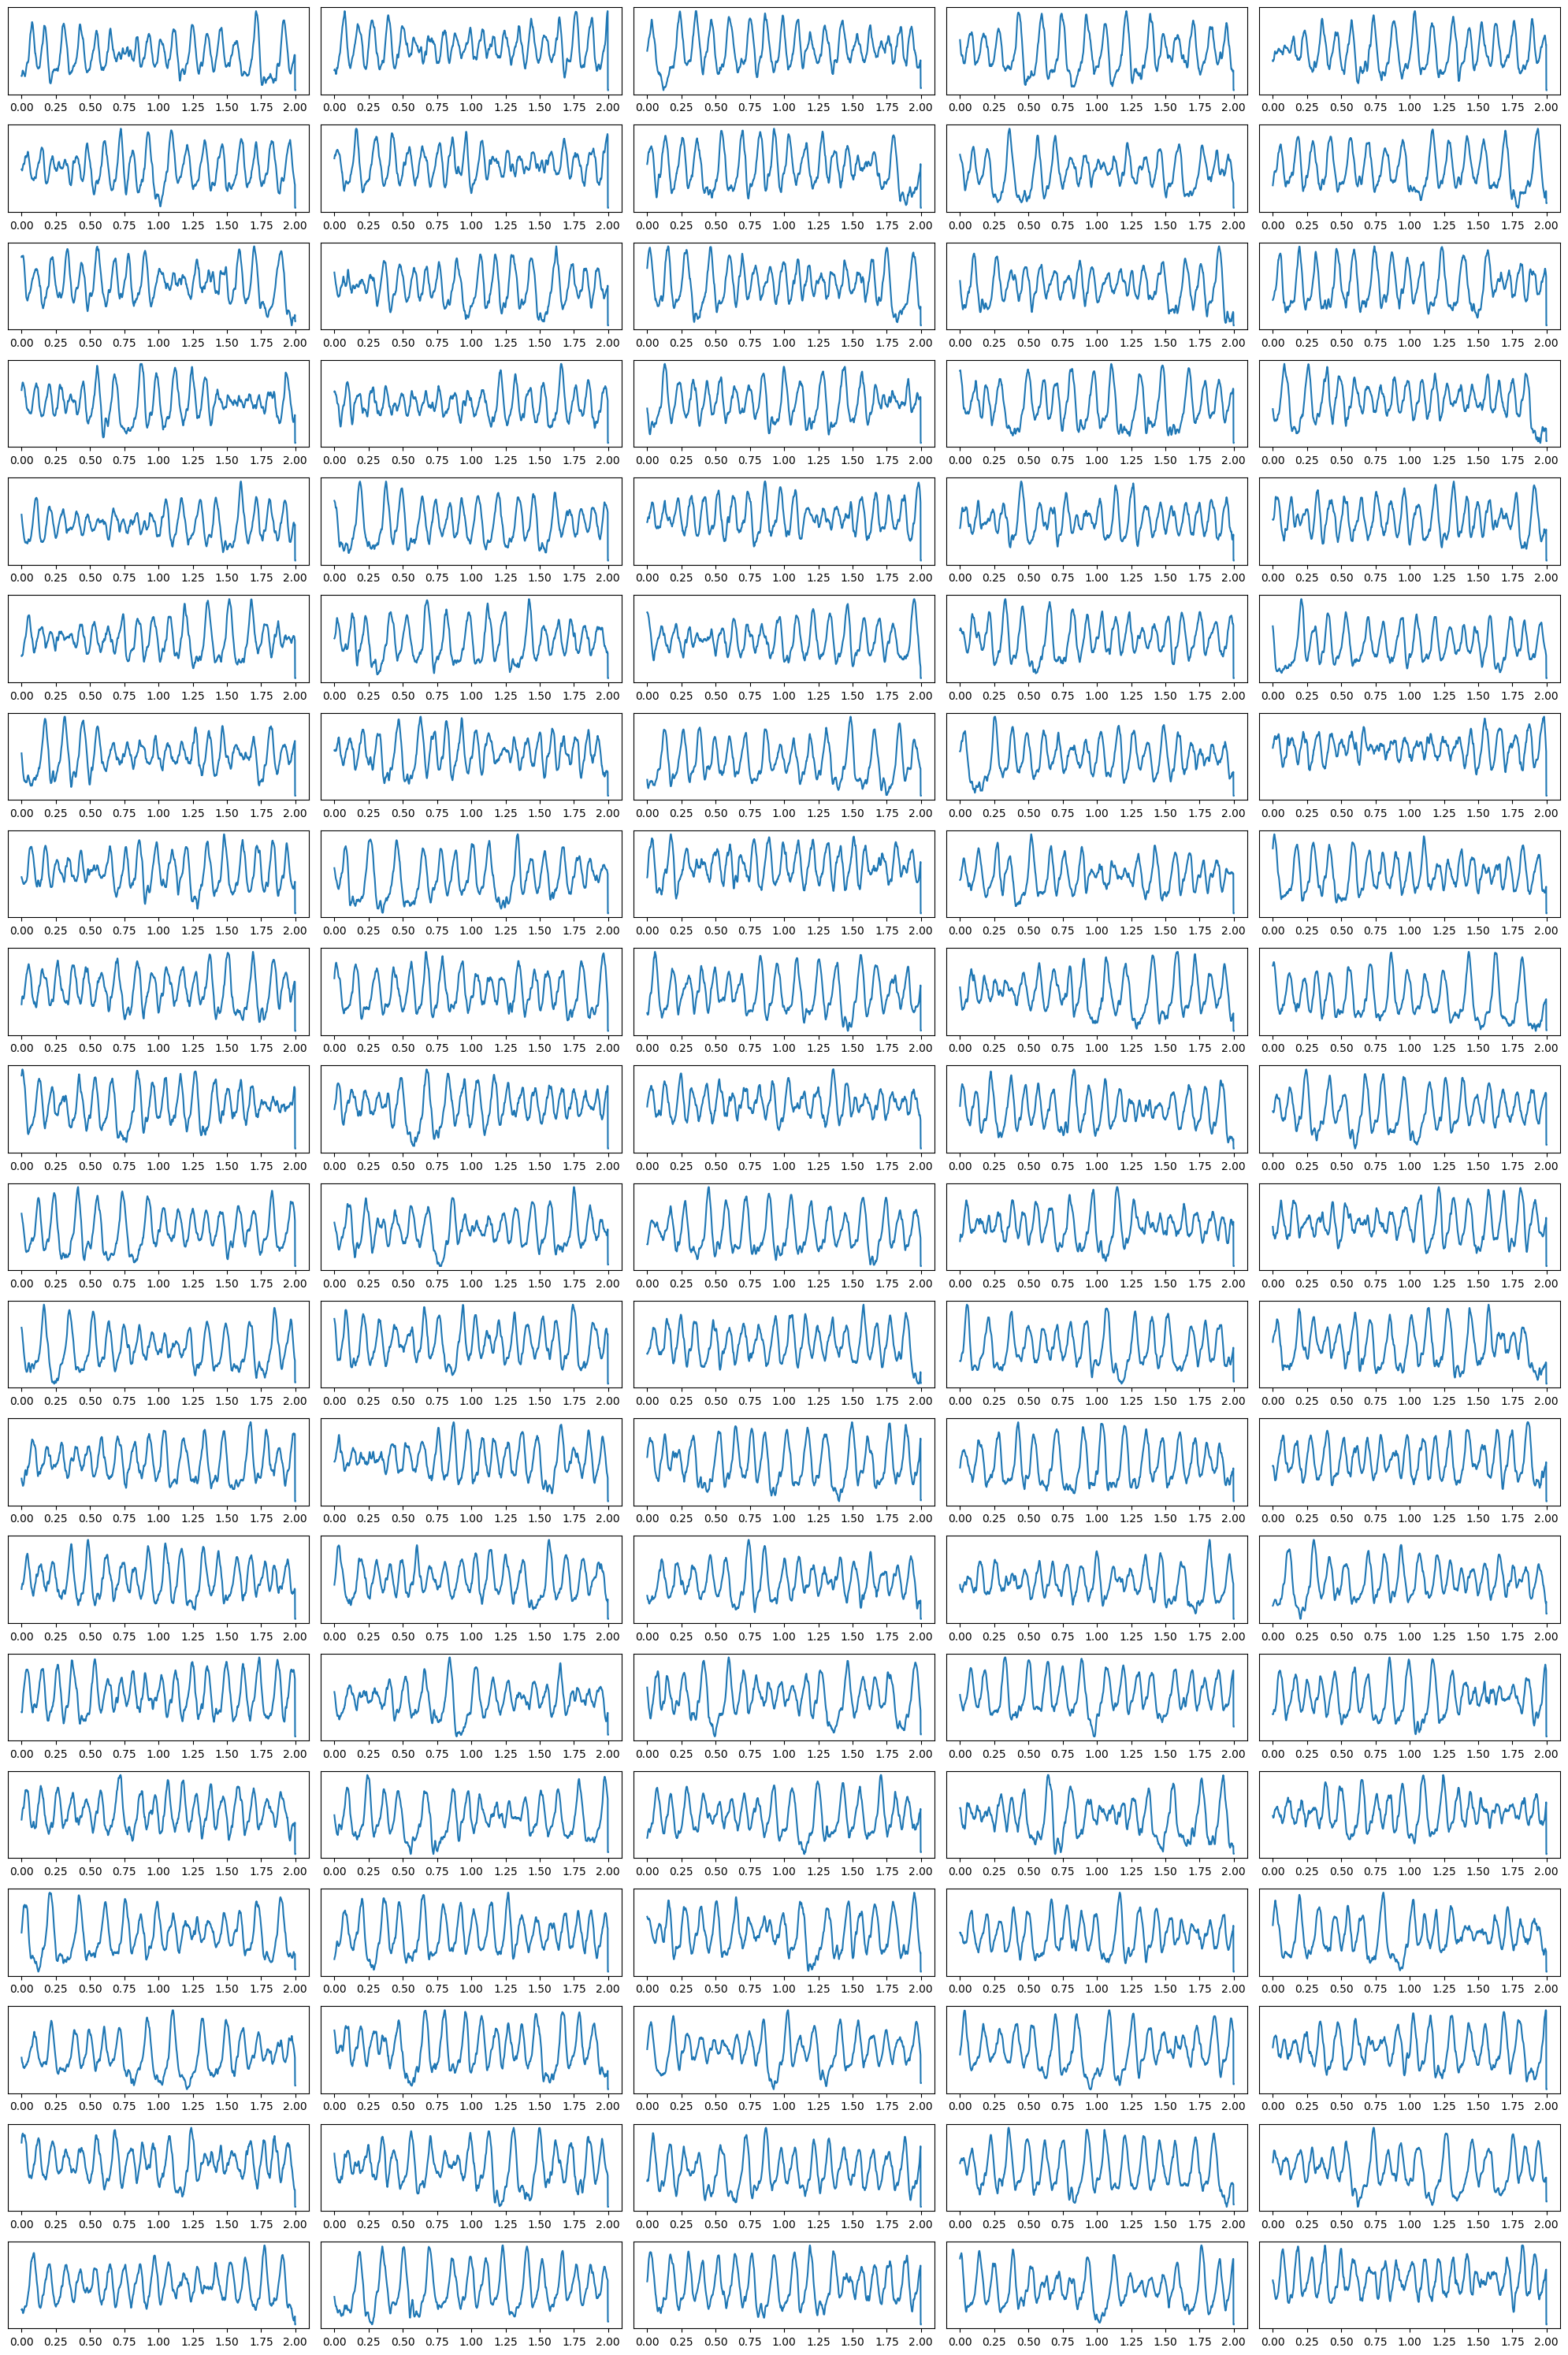

In [105]:
fig, ax = plt.subplots(nrows=20, ncols=5, figsize=(20, 30))

node = 0
for row in ax:
    for col in row:
        col.plot(time_seconds,  V_T_plot[:, node])
        col.tick_params(left=False, labelleft=False)
        node += 1 
    plt.tight_layout()

plt.show()

600059


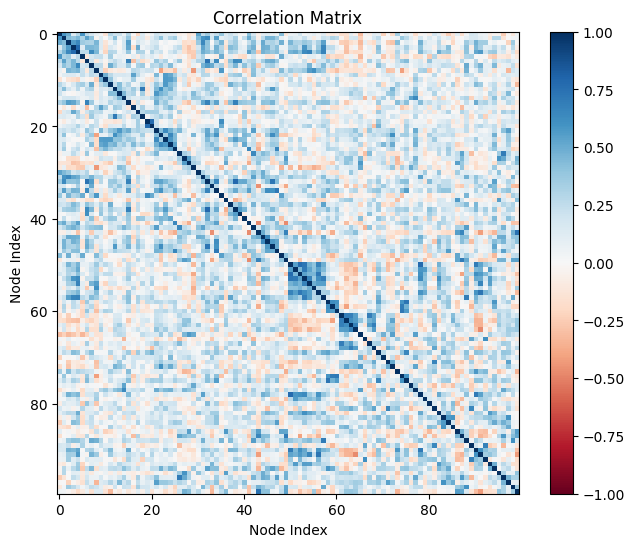

Pearson correlation coefficient: 0.3068025685406732


In [103]:
from scipy import signal
%run BOLD_Model.ipynb

# As J&R model already run with downsampling for eeg, need to adjust downsampling rate
adjusted_downsample = int(downsample_bold / downsample_eeg)

# Initial conditions
initial_conditions = np.array([[0.1, 1, 1, 1]] * num_nodes).T

total_bold_downsampled_sims = int(total_downsampled_sims / adjusted_downsample)

# Array to store results
BOLD_vars = np.zeros((total_downsampled_sims + 1 , 4, num_nodes))
BOLD_vars[0] = initial_conditions
BOLD_temp = np.copy(initial_conditions)

print(total_downsampled_sims)
# Run simulation using Euler method, NOTE - total_downsampled_sims is the number of timepoints we have firing rates for 
for i in range(total_downsampled_sims):
    # dt has to match the sampling frew of what you pass into the BOLD model, in this case it is the data already 
    # downsampled by eeg freq
    BOLD_temp += (1/eeg_freq) * np.array(balloon_windkessel_ode(BOLD_temp, i))
    BOLD_vars[i] = np.copy(BOLD_temp)

#Downsample by adjusted rate
BOLD_vars = BOLD_vars[::adjusted_downsample]

# Take final half of results as simulation points
BOLD_sim_length = int(1/2 * total_bold_downsampled_sims)
BOLD_vars_result = BOLD_vars[-BOLD_sim_length:]

# Initialize BOLD array - will only take the final BOLD_sim_length timepoints
BOLD_array = np.zeros((BOLD_sim_length - 1, num_nodes))

# Generate BOLD array
q = BOLD_vars_result[:-1, 3, :]
v = BOLD_vars_result[:-1, 2, :]

BOLD_array = V_0 * (k1 * (1 - q) + k2 * (1 - (q / v)) + k3 * (1 - v))

# Pass BOLD signals through bandpass filter

Fmin, Fmax = 0.01, 0.1
tr = 1 / bold_freq
a0, b0 = signal.bessel(3, [2 * tr * Fmin, 2 * tr * Fmax], btype = 'bandpass')
BOLDfilt = signal.filtfilt(a0, b0, BOLD_array[:,:], axis = 0)

# Calculate the FC from the filtered BOLD signal

FC_matrix = np.corrcoef(BOLDfilt.T)

plt.figure(figsize=(8, 6))
plt.imshow(FC_matrix, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

# Calculate goodness of fit for BOLD data ####################################################

# Load the empricical (averaged) FC matrix
observed_fc_matrix = np.load("fc_matrices/averaged_fc_matrix.npy")

# Flatten both and use pearson correlation to calculate goodness of fit
pearson_corr = np.corrcoef(np.ravel(FC_matrix), np.ravel(observed_fc_matrix))[0, 1]

print("Pearson correlation coefficient:", pearson_corr)

In [107]:
import os 
import mne
from scipy.stats import pearsonr
eeg_raw_data_dir = 'C:/Users/stapl/Documents/CDocuments/FinalYearProject/Model/eeg_raw_data'

all_channels_data = {} # Will be of length 68 as this is max channels

smallest_ch_samples = 74255 #precalculated

i = 0
for filename in os.listdir(eeg_raw_data_dir):
    if i < 10:
        eeg_path = os.path.join(eeg_raw_data_dir, filename)
        raw = mne.io.read_raw_fif(eeg_path, preload=True)
        for ch in raw.ch_names:
            # Different samples have different time points! 
            channel_samples = raw[ch, 0:smallest_ch_samples][0] # Take first of tuple, as second item is the time
            if ch in all_channels_data.keys():
                all_channels_data[ch].append(channel_samples)
            else:
                all_channels_data[ch] = [channel_samples]
        i += 1

for ch in all_channels_data.keys():
    stacked_data = np.stack(all_channels_data[ch])
    average_array = np.mean(stacked_data, axis=0)
    all_channels_data[ch] = average_array

emp_data = np.squeeze(np.stack(list(all_channels_data.values())))
info = mne.create_info(list(all_channels_data.keys()), sfreq=eeg_freq, ch_types='eeg')
emp_raw = mne.io.RawArray(emp_data, info)
emp_spec = emp_raw.compute_psd(fmin=0, fmax=80, picks="all")
emp_spec.plot(picks="all", average=True, color="Blue");

gen_data = V_T_sim.T
fake_info = mne.create_info(100, sfreq=eeg_freq)
gen_raw = mne.io.RawArray(gen_data, fake_info)
gen_spec = gen_raw.compute_psd(fmin=0, fmax=80, picks="all")
gen_spec.plot(picks="all", average=True, color="Red"); 

# mean_emp = 
# mean_gen = 

# Compute and print the Pearson correlation between the PSDs
# correlation_coefficient, _ = pearsonr(psd_gen.mean(axis=0), psd_emp.mean(axis=0))
# # Or take correlation then find the mean 
# print("Pearson correlation coefficient between generated and empirical PSDs:", correlation_coefficient)

Opening raw data file C:/Users/stapl/Documents/CDocuments/FinalYearProject/Model/eeg_raw_data\filt_chanrej_SASICA_MARA_0162_081610_RestEyesClosed_DvP_1_preprocessed-raw.fif...
    Range : 0 ... 287827 =      0.000 ...   287.827 secs
Ready.
Reading 0 ... 287827  =      0.000 ...   287.827 secs...
Opening raw data file C:/Users/stapl/Documents/CDocuments/FinalYearProject/Model/eeg_raw_data\filt_chanrej_SASICA_MARA_0234_102011_RestEyesClosed_DVP_1_preprocessed-raw.fif...
    Range : 0 ... 287532 =      0.000 ...   287.532 secs
Ready.
Reading 0 ... 287532  =      0.000 ...   287.532 secs...
Opening raw data file C:/Users/stapl/Documents/CDocuments/FinalYearProject/Model/eeg_raw_data\filt_chanrej_SASICA_MARA_0332_042410_RestEyesClosed_RS_1_preprocessed-raw.fif...
    Range : 0 ... 282238 =      0.000 ...   282.238 secs
Ready.
Reading 0 ... 282238  =      0.000 ...   282.238 secs...
Opening raw data file C:/Users/stapl/Documents/CDocuments/FinalYearProject/Model/eeg_raw_data\filt_chanrej_SAS

c:\Users\stapl\anaconda3\envs\nilearnenv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\stapl\anaconda3\envs\nilearnenv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


In [181]:
import mne
import numpy as np
import pandas as pd
from mne.datasets import fetch_fsaverage
from scipy.interpolate import NearestNDInterpolator as Interpolator
from mne.datasets import fetch_fsaverage

src = mne.read_source_spaces('C:/Users/stapl/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif')
# Get positions and orientations
fsaverage_pos = np.array(src[1]['rr'])  # Vertex positions (3, 163842). 3D, sources (ignoring left/right hemisphere)
fsaverage_ori = np.array(src[1]['nn'])  # Vertex orientations (3, 163842)

#rr coordinates, nn vector normals 

df = pd.read_csv('Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')

schaefer_pos = df[['R', 'A', 'S']].values # produces (100, 3) where index is the ROI label
# schaefer_pos = df[['R', 'A', 'S']].values.astype(float) / 1000.0 # Converting to metres to be the same as fsaverage

schaefer_ori = np.zeros(schaefer_pos.shape)

for i in range(3):
    interp = Interpolator(fsaverage_pos, fsaverage_ori[:, i])
    schaefer_ori[:, i] = interp(schaefer_pos[:, 0], schaefer_pos[:, 1], schaefer_pos[:, 2])

old_info = raw_eeg_file.info 

new_info = mne.create_info(ch_names=old_info['ch_names'], sfreq=old_info['sfreq'], ch_types='eeg')
new_info.set_montage('standard_1020')  # Set the montage to standard 10-20 system

trans = 'C:/Users/stapl/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-trans.fif'

schaefer_positions_dict = {
    'rr': schaefer_pos,
    'nn': schaefer_ori
}

source_space = mne.setup_volume_source_space(pos=schaefer_positions_dict)

print(fsaverage_pos[0])
print(schaefer_pos[0])

mne.viz.plot_alignment(
    new_info,
    trans,
    src=src,
    dig=True,
    eeg=dict(original=1),
    surfaces="brain", 
)

# mne.viz.plot_sensors(
#     new_info,
#     kind='3d'
# )


    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
Sphere                : origin at (0.0 0.0 0.0) mm
              radius  : 95.0 mm
Source location file  : dict()
Assuming input in millimeters
Assuming input in MRI coordinates

Positions (in meters) and orientations
100 sources
[ 0.02765008 -0.01443069  0.06016058]
[-26 -34 -18]
Channel types::	eeg: 19


In [7]:
# Make BEM model #######################
fs_dir = "C:/Users/stapl/mne_data/MNE-fsaverage-data/"

model = mne.make_bem_model(
    subject='fsaverage',
    ico=4,
    conductivity=(0.3, 0.006, 0.3),
    subjects_dir=fs_dir,
)

bem = mne.make_bem_sol_eegution(model)


Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
outer skin  CM is  -0.21 -19.38  -0.23 mm
outer skull CM is  -0.19 -19.34  -0.49 mm
inner skull CM is  -0.53 -21.10   6.21 mm
Checking that surface outer skull is inside surface outer skin  ...
Checking that surface inner skull is inside surface outer skull ...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    1.6 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately    5.4 mm
Surfaces passed the basic topology checks.
Complete.

Three-layer model surfaces loaded.
Computing the linear collocation solution...
    Matrix coefficients...
     

In [180]:
fsaverage = fetch_fsaverage(verbose=True)
subject_dir="C:/Users/stapl/mne_data/MNE-fsaverage-data"

# Scatter plot with eeg points, schaefer pos and fsaverage source positions 

# fig = mne.viz.plot_alignment(
#     #src=source_space,
#     trans='fsaverage',
#     bem=bem,
#     surfaces='brain',
# )

mne.viz.plot_alignment(
    info=new_info,
    trans=trans,
    subject='fsaverage',
    surfaces=dict(head=0.5, brain=0.5),
    eeg=True,
    dig=True,
)

#Getting an empty plot

0 files missing from root.txt in C:\Users\stapl\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\stapl\mne_data\MNE-fsaverage-data\fsaverage


Using outer_skin.surf for head surface.
Channel types::	eeg: 19


In [182]:
# Create the forward sol_eegution ##################
fwd = mne.make_forward_sol_eegution(
    info=new_info,
    trans=trans,
    src=source_space,
    bem=bem,
    eeg=True,
    n_jobs=None,
    verbose=True,
)



Source space          : <SourceSpaces: [<discrete, n_used=100>] MRI (surface RAS) coords, ~8 kB>
MRI -> head transform : C:\Users\stapl\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 1 source spaces a total of 100 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  19 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surfa

RuntimeError: No points left in source space after excluding points close to inner skull.

    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]
(600, 100)
(19, 100)


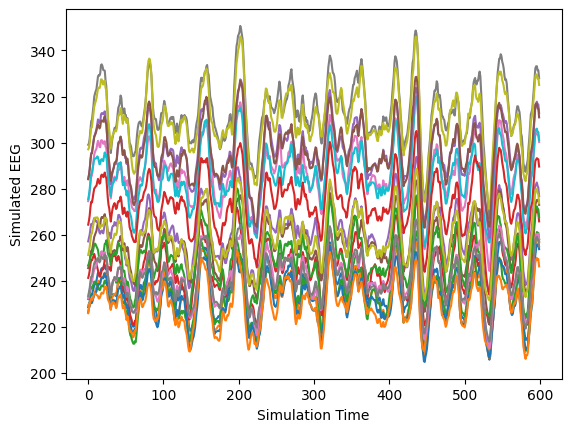

In [159]:
import mne
fwd_fixed = mne.convert_forward_sol_eegution(fwd, force_fixed=True)

# data contains The forward sol_eegution data. 
# The shape will be (n_channels, nsource) for a fixed-orientation forward and (n_channels, nsource * 3) for a free-orientation forward.
# SO must first convert to fixed orientation 

leadfield_fixed = fwd_fixed["sol_eeg"]["data"]

leadfield_normalised = (leadfield_fixed - np.min(leadfield_fixed)) / (np.max(leadfield_fixed) - np.min(leadfield_fixed))

print(V_T_sim.shape) # (150015, 100)
print(leadfield_normalised.shape) # (19, 100)

# print(fwd['sol_eeg']['row_names']) 
# ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4', 'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']

# Pick 4 of the shaefer sources  - then look at where the 19 EEG channels
# Min x, max x, min y, max y 
# negative x means left, negative y means back

# 600x100 * 100x19 = 600x19
simulated_eeg = np.dot(V_T_sim, leadfield_normalised.T)

for node in range(19):
    plt.plot(simulated_eeg[:, node], label=f'Node {node+1}')

plt.xlabel('Simulation Time')
plt.ylabel('Simulated EEG')

# Add legend to the right of the plot
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Z score on each channel

ValueError: Data and pos need to be of same length. Got data of length 100, pos of length 19

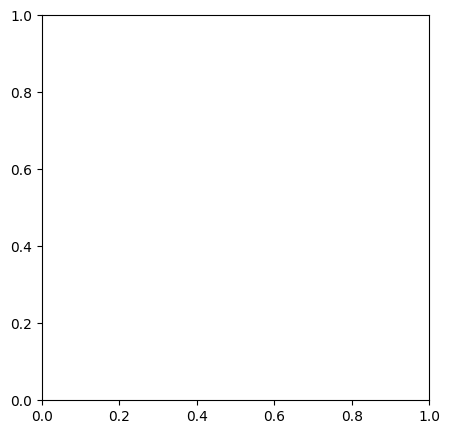

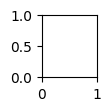

: 

In [268]:
# n_sensors = len(fwd_fixed['info']['chs'])  # 19 EEG nodes
# n_sources = leadfield_normalised.shape[1]  # 100 parcels

# # Create layout from the montage
# layout = mne.channels.make_eeg_layout(info=new_info)

# # Create a figure with subplots for each EEG node
# fig, axes = plt.subplots(5, 4, figsize=(15, 12))
# axes = axes.flatten()

# # Plot the contribution of each source to each EEG node
# for sensor_idx in range(n_sensors):
#     # Get the contributions of all sources to the current EEG node
#     contributions = leadfield_normalissed[sensor_idx, :]  # Shape (100,)

#     # Plot topographic map
#     mne.viz.plot_topomap(contributions, layout.pos[:, :2], cmap="Spectral_r", axes=axes[sensor_idx],
#                           sensors=True, show=False)
    
#     axes[sensor_idx].set_title('EEG Node {}'.format(sensor_idx))

# plt.tight_layout()
# plt.show()



